#### Title: Classifying Red Wine Quality - Group 21

#### Introduction

"Vinho Verde'' is a Portuguese wine which has three main variants, of which we will be considering red. In the kaggle dataset we are using from UCI Machine Learning, its quality is affected by 11 different physicochemical variables, such as acidity, chlorides, density, etc.. These 11 variables determine the quality of the wine, on a scale from 0-10. We will conduct our data analysis using three predictors from our dataset: total acidity, alcohol content, and pH. However, since total acidity is not technically within the dataset, we will have to combine the values of fixed and volatile acidity, creating a new column for total acidity.

Our ultimate goal is to create a k-nearest neighbors classifier (built off of our dataset) to classify the quality of various red wines at different price points that are sourced from outside of the dataset. This will ultimately help us determine whether or not the differences in the qualities of the wines generally correspond to their differences in price. We can rephrase this as a predictive research question: Using a k-means classifier, does a difference in the quality of a red wine reflect a difference in its price?

#### Methodology

We decided on the three predictors outlined above due to the online accessibility of this information; many red wine companies do not share the finer contents of their wines, such as sulfur dioxide, density, volatile and citric acids, etc. However alcohol content, total acidity, and pH are far more easily found and therefore the best predictors to answer our question, especially important considering that we are sourcing wines from the internet.

Since this proposal is a classification task, we will build a classifier to categorize wines as either good or poor in quality - for which we will be using the K-nearest neighbors classification algorithm. The classifier will be trained to recognize the quality of wine based on the three predictors outlined above. We will define good quality wine as having a quality rating over _6.5_ and anything below as poor quality - a threshold set by the creator of the dataset. The good quality wines will be assigned _1_ and the poor quality wines will be assigned _0_. This is done for the purpose of making a binary classifier, rather than a multiclass one, creating more concrete distinctions between the qualities of the wines and avoiding an unecessarily complex model that may have lower accuracy. Additionally, since each variable has a small range of values, it will already prove difficult to accurately classify each wine into such specific qualities. Thus, creating a binary classifier eliminates this problem, since there are only two, broad classes to consider.

In our preliminatory data visualization, we will use a ggpairs matrix to examine the general relationship between the wine class (good or poor) and our chosen predictors, giving us an idea of what parameters to expect in our classifier. The plot will help us see the mean values of each predictor that fall into either class. When we build the classifier, we will have to tune the number of neighbors and create a line plot to show at which *k* the classifier takes on the highest accuracy. These are the visuals to be expected.

#### Preliminary exploratory data analysis

In [1]:
remove.packages("lifecycle")
install.packages("lifecycle")

Removing package from ‘/opt/conda/lib/R/library’
(as ‘lib’ is unspecified)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [15]:
library(dplyr)
library(tidymodels)
library(tidyverse)
options(repr.matrix.max.rows = 6)
install.packages("themis")
library(themis)
install.packages("kknn")
library("kknn")
install.packages("GGally")
library(GGally)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



After loading in the necessary libraries, we first read in the red wine data, using the "mutate" and "ifelse" functions in conjunction to create a new column, distinguishing the wines as either good or poor. The original dataset sets the threshold for a good wine at >6.5 and we followed this in our code. We called this new column "new_quality" to make it distinct from the existing "quality" column, and it only contains 0s and 1s to indicate the binary wine quality. In order to use total acidity as a predictor, we use the mutate function to combine the values of the two existing acidity columns. Finally, we removed white spaces from between the column names to be able to later call on them, tidying the data.

In [16]:
options(repr.matrix.max.rows = 6)

red_wine <- read_csv("data/winequality-red.csv")|>
    mutate(new_quality = ifelse(quality < 6.5, 0, 1)) |>
    mutate(new_quality = as_factor(new_quality))

colnames(red_wine) <- make.names(colnames(red_wine))

red_wine <- red_wine |>
    mutate(total.acidity = fixed.acidity + volatile.acidity)
red_wine

Rows: 1599 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (12): fixed acidity, volatile acidity, citric acid, residual sugar, chlo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,new_quality,total.acidity
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,0,8.10
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5,0,8.68
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5,0,8.56
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
6.3,0.510,0.13,2.3,0.076,29,40,0.99574,3.42,0.75,11.0,6,0,6.810
5.9,0.645,0.12,2.0,0.075,32,44,0.99547,3.57,0.71,10.2,5,0,6.545
6.0,0.310,0.47,3.6,0.067,18,42,0.99549,3.39,0.66,11.0,6,0,6.310


Before we build our classifier, we can visualize and create tables for the original data to extract more information from it. We chose to create a simple ggpairs matrix to simultaneously observe the relationships between our chosen predictors and the binary wine quality. Since we are interested in how the quality varies with each predictor, we focussed on the rightmost four graphs in the matrix (3 boxplots and 1 bargraph).

Observing the graph of new quality v. total acidity, we noticed that wines falling in the "good" class or the 1 class had a higher mean total acidity. Observing the graphs for the other two predictors, good quality wines had a higher mean alcohol content and lower average pH. However, the differences between these averages are not significant, suggesting that the classifier may have difficulty distinguishing between qualities given the small range of alcohol, total acidity, and pH values.

The proportion of good wines to poor wines was also noted in the bottom right bar graph, showing how good wine is a minority class. This indicates that the data will have to be balanced or upscaled at some point in the analysis to avoid the classifier being biased towards the majority class - poor quality wine - when making predictions on the testing data.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



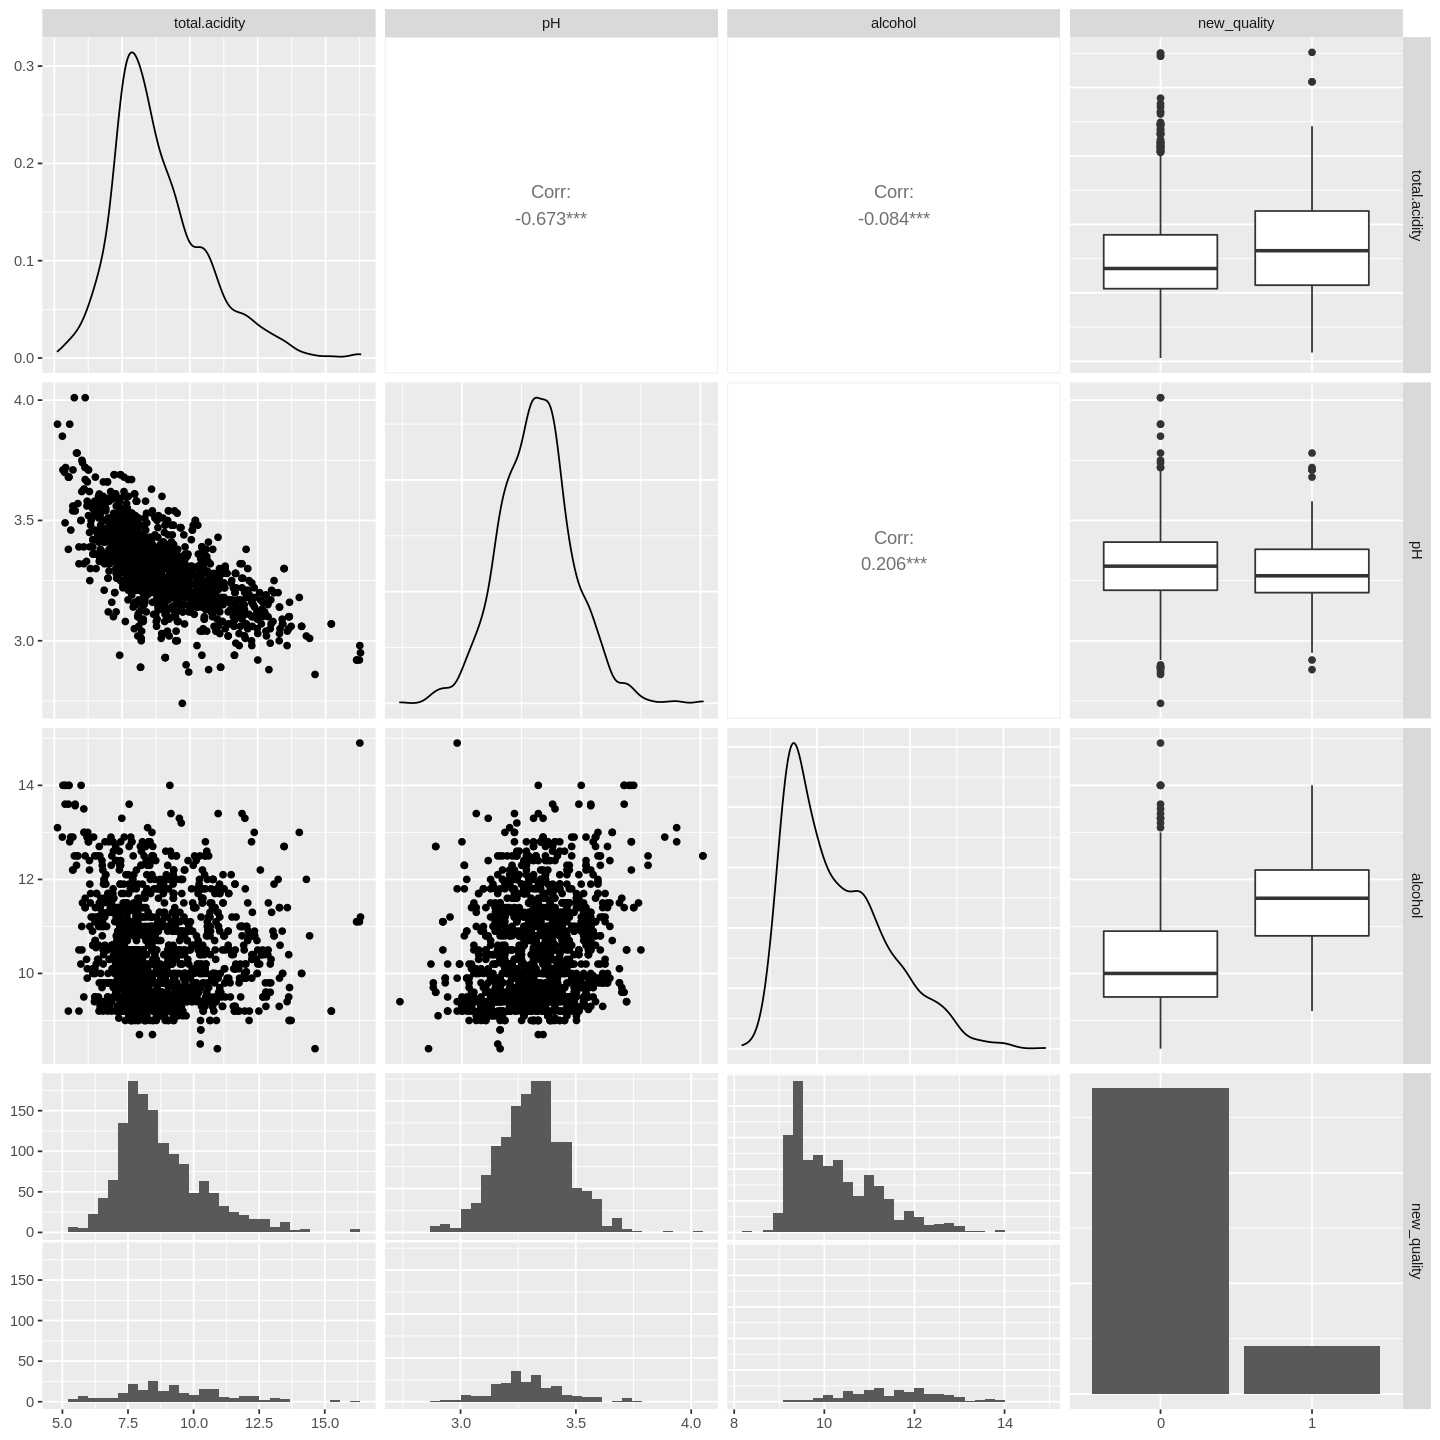

In [17]:
options(repr.plot.height = 12, repr.plot.width = 12)

my_ggpairs <- ggpairs(red_wine, columns = c("total.acidity", "pH", "alcohol", "new_quality"))
my_ggpairs

Following the visualization, we created three more informative tibbles. The first of these shows the mean values of each predictor which, though not explicitly relevant, does show that the predictors have different scales and that they will need to be normalized in the analysis to create a reliable classifier. The second tibble shows the exact proportion of poor to good wines, with good wines making up only 13.5% of the dataset - further indication that we should balance it in the analysis. Finally, we determine that there are no missing values in the dataset. This preliminary exploration of the data informs our decisions in the analysis portion of the proposal.

In [18]:
red_wine_quality_count <- red_wine |>
    group_by(new_quality) |>
    summarize(count = n())

missing_data <- red_wine |>
    summarize(empty_rows = sum(is.na(" ")))

red_wine_mean <- red_wine |>
    select(-quality, -new_quality) |>
    summarize(across(fixed.acidity:total.acidity, mean))

red_wine_mean
red_wine_quality_count
missing_data

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,total.acidity
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
8.319637,0.5278205,0.2709756,2.538806,0.08746654,15.87492,46.46779,0.9967467,3.311113,0.6581488,10.42298,8.847458


new_quality,count
<fct>,<int>
0,1382
1,217


empty_rows
<int>
0


To train the k-means classifier, we split the mutated red wine data into 75% training and 25% testing data. We specified that the class on which to base the splitting was new_quality, as this is the class we will be working with. In order to make our code reproducible, we set a seed at the beginning, ensuring that the same random sequences of numbers are considered for the outputs.

In [31]:
set.seed(1930)
red_wine_split <- initial_split(red_wine, prop = 0.75, strata = new_quality)

red_wine_train <- training(red_wine_split)

red_wine_test <- testing(red_wine_split)

Now having the testing and training data, we created a recipe for the training data with the three predictors outline in the introduction - alcohol, pH, and total acidity. We scaled and centered all the predictors in the recipe to ensure that every predictor has an equal influence over the model. We also chose to upsample the underepresented "good" quality wines as they only comprised 13.5% of the original data. This is done to prevent the classifier from being biased to the overepresented "poor" quality wines and making inaccurate predictions.

We then created a knn model, specifying the task to be classification, and set the neighbors to tune(), since we needed to optimize the k value we would use in the final model. The number of neighbors considered in the cross validation will be from 1-10, sequentially.

In [35]:
set.seed(2000)

wine_recipe <- recipe(new_quality~ alcohol + pH + total.acidity, data = red_wine_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |> 
    step_upsample(new_quality, over_ratio = 1, skip = FALSE)

wine_upscaled <- wine_recipe |>
    prep() |>
    bake(red_wine_train)

wine_recipe_upscaled <- recipe(new_quality~ alcohol + pH + total.acidity, data = wine_upscaled)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

wine_vfold <- vfold_cv(red_wine_train, v = 10, strata = new_quality)

kvals <- tibble(neighbors = seq(1,10))

With the recipe and model created, we passed them into the workflow and generated results for various mean accuracies corresponding to various numbers of neighbors. To determine the optimal k, we created a plot of the mean vs. neighbors, identifying this value of k to be 7, as seen below.

In [ ]:
set.seed(2000)

options(repr.max.plot.width = 6, repr.max.plot.height = 6)


wine_results <- workflow() |>
    add_recipe(wine_recipe_upscaled) |>
    add_model(knn_tune) |>
    tune_grid(resamples = wine_vfold, grid = kvals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")|>
    arrange(desc(mean))

accuracy_versus_k <- ggplot(wine_results, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate")

accuracy_versus_k
wine_results

Having our optimal *k* (either 1 or 2), we recreated our classification model, fitting the recipe and model to our training data after passing it through the workflow. The testing data was then used to generate accuracy metrics for the classifier, including a confusion matrix. From this, we gathered that our final classifier has a reasonable accuracy of 88% using *k* = 9.

In [34]:
knn_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
    set_engine("kknn") |>
    set_mode("classification")

wine_fit <- workflow() |>
       add_recipe(wine_recipe_upscaled) |>
       add_model(knn_2) |>
       fit(data = red_wine_train)

wine_test_predictions <- predict(wine_fit, red_wine_test) |>
       bind_cols(red_wine_test) |>
       metrics(truth = new_quality, estimate = .pred_class) 

wine_mat <- predict(wine_fit, red_wine_test) |>
       bind_cols(red_wine_test) |> 
       conf_mat(truth = new_quality, estimate = .pred_class)

wine_test_predictions
wine_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8778055
kap,binary,0.3617346


          Truth
Prediction   0   1
         0 334  37
         1  12  18

Using our knowledge of classification, we successfully built a reliable k-means model that can classify wines into two categories - good or poor - based on their pH, alcohol, and levels of total acidity. With this model, it is now possible to predict the qualities of red wines sourced outside of our dataset. To involve variety in our choices, we selected cheap, medium-priced, and expensive wines from a single website, taking their predictor details and creating new tibbles for each one. We then passed these new observations through the predict function with our fitted model.

We decided, in terms of dollars, that the criteria for a cheap wine is <100, that for a medium wine, it is 100-1000 and that for an expensive wine, it is >1000.

In [30]:
cheap_wine <- tibble(pH = 3.58,
                   total.acidity = 6.3,
                    alcohol = 13.9)

cheap_wine_2 <- tibble(pH = 3.77,
                   total.acidity = 5.3,
                    alcohol = 13.5)

cheap_wine_3 <- tibble(pH = 3.76,
                   total.acidity = 5.3,
                    alcohol = 14.5)

medium_wine <- tibble(pH = 3.7,
                   total.acidity = 7.07,
                    alcohol = 14.5)

exp_wine <- tibble(pH = 3.62,
                   total.acidity = 6.9,
                    alcohol = 13.5)

cheap_wine_predict <- predict(wine_fit, cheap_wine)
cheap_wine_2_predict <- predict(wine_fit, cheap_wine_2)
medium_wine_predict <- predict(wine_fit, medium_wine)
exp_wine_predict <- predict(wine_fit, exp_wine)
cheap_wine_3_predict <- predict(wine_fit, cheap_wine_3)

cheap_wine_predict
medium_wine_predict
exp_wine_predict
cheap_wine_2_predict
cheap_wine_3_predict

.pred_class
<fct>
1


.pred_class
<fct>
1


.pred_class
<fct>
0


.pred_class
<fct>
1


.pred_class
<fct>
1


#### Discussion of Results

- What results say about price-quality relationship
- What it says about the reliability of the classifier
- Significance of the findings
- Deviation from expectations

#### Strengths

The strengths of our classifier can be attributed to our manipulation of the data before the final classification model. By changing what would have been a multiclass classifier into a binary classifier (with the introduction of new_quality), our classification results were easy to interpret and more accurate than one would have been, had it accounted for 10 different classes. By standardizing and balancing the data, we ensured that the model considered all values equally and that the underrepresented class was not ignored. In order to avoid underfitting or overfitting the data, we tuned our *k* values with cross-validation, ensuring that the final model used the number of neighbors that would yield the highest accuracy. Given our data wrangling, the model itself, not considering external data, is a strong classifier

#### Limitations

Given the inaccuracies in the predictions of the wines sourced from the internet, the classifier also falls short in a number of ways. Firstly, the limited online information of wine makeup meant that we could only use 3 predictors, when using more would have allowed higher accuracy in both the classifier and its predictions of these outsourced wines. If our team had access to a website where we were given wines from a range of prices, and with their exact chemical composition, this would have made our research question easier to answer.

While we cannot say that using a Vinho Verde-specific classifier to classify the qualities of non-Vinho Verde wines is completely *inaccurate*, since wine quality is assessed on universal physico-chemical wine properties, it is important to consider that the wines in this data
set are specifically Vinho Verde. Whereas, the wines we sourced from the internet are not necessarily Vinho Verde. This was done to avoiding use Vinho Verde wines from the internet that were already included in the data set. However, this indicates that the standard for good quality wines may be different, and that the predicted qualities of these wines do not necessarily reflect their actual qualities. This could be shown by the inaccuracies in how the differently priced wines are classified; cheap (non-Vinho Verde) wines classified as good quality are not necessarily good quality and this limitation is made worse by the low number of predictors available to us. 

#### References

P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.


Red wine. WeSpeakWine.com. (n.d.). Retrieved April 14, 2023, from https://www.wespeakwine.com/categories/Wine-Type/Red-Wine?sort=PriceDesc&amp;catID=3566 